In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibm_perth"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 4
reps = 8
max_num_itrs = 10

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9946, 0.0054], [0.009399999999999964, 0.9906]],
 'gate_qubits': [(6,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-06-15 06:02:35-04:00


In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
from qiskit.circuit.library import EfficientSU2
def single_iter(n_qubits=4):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.cx(2,3)
    iterate.barrier()
    iterate.cx(2,3)
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=3, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

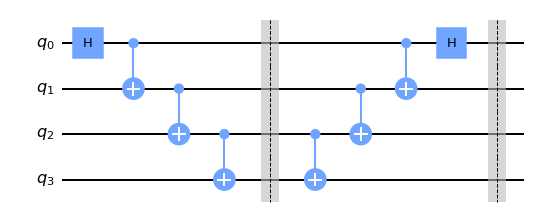

In [8]:
single_iter(n_qubits).draw("mpl")

12


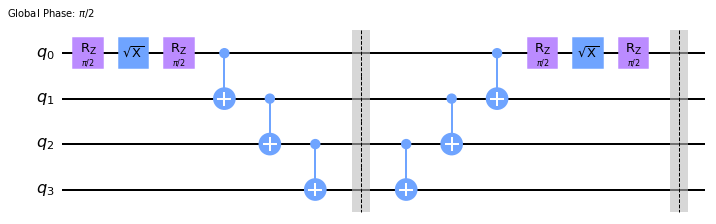

In [9]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [10]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 186
T1: 0.00018159430335748367 sec
T2: 7.821454993913367e-05 sec
Circuit Operation Time: 6.485333333333333e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [11]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [12]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'1000': 718,
 '0000': 56121,
 '0100': 1085,
 '0110': 320,
 '0111': 267,
 '0001': 3624,
 '0010': 2126,
 '0011': 882,
 '0101': 278,
 '1001': 57,
 '1100': 13,
 '1010': 32,
 '1101': 1,
 '1011': 9,
 '1110': 2,
 '1111': 1}

In [13]:
total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9430354760588298
0.8904334398424542
0.8418420164684104
0.7969384291131676
0.7554265590016018
0.7170347117795332
0.6815135727143676
0.6486343346676758
0.6181869841540527
0.5899787320538359

Prob Vec
[9.07882690e-01 3.09295654e-02 2.42309570e-02 5.09643555e-03
 1.49688721e-02 1.73950195e-03 2.01416016e-03 1.32751465e-03
 1.09252930e-02 2.89916992e-04 2.59399414e-04 3.05175781e-05
 2.59399414e-04 3.05175781e-05 1.52587891e-05 0.00000000e+00]
[8.82049561e-01 4.28619385e-02 2.84576416e-02 9.73510742e-03
 1.55334473e-02 2.65502930e-03 3.23486328e-03 3.21960449e-03
 1.10168457e-02 3.96728516e-04 3.20434570e-04 1.22070312e-04
 2.74658203e-04 4.57763672e-05 3.05175781e-05 4.57763672e-05]
[8.52905273e-01 5.63659668e-02 3.27911377e-02 1.44805908e-02
 1.65252686e-02 5.14221191e-03 4.71496582e-03 4.30297852e-03
 1.11999512e-02 6.71386719e-04 3.35693359e-04 1.83105469e-04
 2.13623047e-04 3.05175781e-05 6.10351562e-05 7.62939453e-05]
[8.31863403e-01 6.76879883e-02 3.45306396e-02 1.75781250e-

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [14]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

In [21]:
tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    print(i)
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

1
2
3
4
5
6
7
8
9
10
Tomography Purity
0.8152508462789277
0.7664834276848138
0.7269498918047455
0.6927681725855653
0.6667487680733711
0.6276116631205919
0.6063104604799029
0.5600315001092855
0.5430250798076516
0.5124884139764604

Tomography Prob Vec
[0.90053897 0.02461913 0.01942234 0.00378508 0.01065548 0.00385027
 0.00553886 0.0038126  0.00874152 0.00582616 0.00361808 0.00123369
 0.00234774 0.00214241 0.00208086 0.00178682]
[0.87132524 0.03834373 0.01970043 0.00904519 0.01516747 0.00390834
 0.0038509  0.00435416 0.0094233  0.00513059 0.00494986 0.00327717
 0.00614105 0.00148804 0.00213021 0.00176432]
[0.84809771 0.0491283  0.03120691 0.00497661 0.01042054 0.00430242
 0.00910374 0.00441166 0.01074336 0.0086002  0.00447315 0.00174051
 0.00545751 0.00215763 0.00230141 0.00287833]
[0.82696991 0.05735285 0.02670366 0.0172537  0.0137399  0.00910712
 0.00731606 0.00534849 0.0119218  0.00433456 0.00454658 0.00149817
 0.00538034 0.00282239 0.0033954  0.00230907]
[0.80997781 0.06479837 0.03095

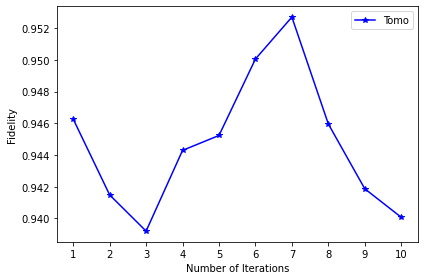

In [22]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    diff_fed_tomo.append(fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.show()

## Kalman Smoother

In [15]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [16]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [37]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

# M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
# Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
# R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
# P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1+1j)# 

In [38]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(256, 256, 16, 65536)

### EM and Smoother - Total

Use longest iterations

In [42]:
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
# realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
# realX0 = KSEM.closed_den_mat(realX0) # find closest valid density matrix
# realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
    x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

Iteration statrts New ll 3512.49, Last ll 3502.49
Iteration     1, New log-likelihood 3.53417e+03, Last log-likelihood 3.51249e+03, Change 2.16820e+01
Iteration     2, New log-likelihood 3.96968e+07, Last log-likelihood 3.53417e+03, Change 3.96933e+07


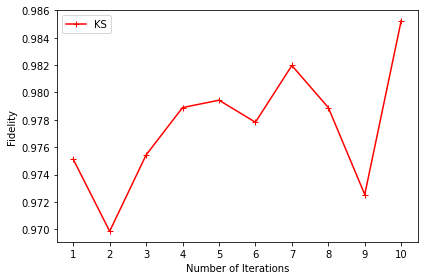

In [43]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
for i in range(max_num_itrs):
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.show()

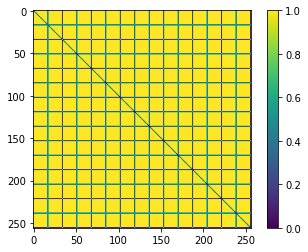

In [44]:
plt.imshow(realQ.real<0)
plt.colorbar()
plt.show()

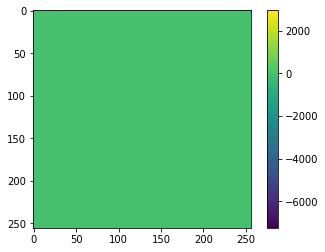

In [45]:
plt.imshow(realQ.real)
plt.colorbar()
plt.show()

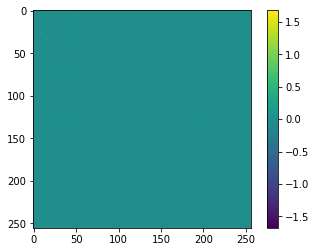

In [46]:
plt.imshow(realQ.imag)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [47]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [48]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [49]:
total_smoother_dens[0].diagonal().flatten()

matrix([[9.12074738e-01+3.06400358e-57j, 2.80105526e-02+2.77064387e-53j,
         2.27798897e-02-1.04109270e-52j, 8.31428128e-03-4.78831529e-52j,
         3.68986251e-04+2.64992991e-51j, 1.77401558e-02+1.63035345e-52j,
         2.51787295e-03-5.06932046e-50j, 5.53122922e-03+2.27210985e-50j,
         2.28594290e-03-9.15419466e-52j, 1.26472308e-04+2.44055416e-50j,
         6.59795188e-07+2.50741565e-52j, 4.77487117e-06+4.14747686e-51j,
         6.82079007e-05+0.00000000e+00j, 1.87098011e-05+0.00000000e+00j,
         9.15741210e-05+0.00000000e+00j, 6.59527083e-05+0.00000000e+00j]])

In [50]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

array([[9.12074738e-01+3.06400358e-57j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 2.80105526e-02+2.77064387e-53j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.000000

In [51]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))

0.000838543005659266
0.0007293429593887095
0.00045282805760878684
0.00041332423709046923
0.0011872274984118841
0.0007899227651936034
0.00023528878514255557
0.0003251826932295312
0.0006096491373294987
0.0002487351837916872


In [52]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.83361071484727
0.7818065834347875
0.7338948738981406
0.6978051685381312
0.6668412084225284
0.6316323868069601
0.6002674083886479
0.5755651171330788
0.5500073840722334
0.5263471073092277


## Check the fidelity between estimated state and the real state in the simulator

In [53]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

Iteration 1 KS Fid: 0.9751238261081819 Tomo Fid: 0.9462696415055912
Iteration 2 KS Fid: 0.96985478815236 Tomo Fid: 0.9414831035581118
Iteration 3 KS Fid: 0.9754318068017725 Tomo Fid: 0.9391995685730516
Iteration 4 KS Fid: 0.9788969755875102 Tomo Fid: 0.9442955286948326
Iteration 5 KS Fid: 0.9794368633695341 Tomo Fid: 0.945235151694162
Iteration 6 KS Fid: 0.9778249835294495 Tomo Fid: 0.9500608415714854
Iteration 7 KS Fid: 0.9819736069946134 Tomo Fid: 0.9527067221627539
Iteration 8 KS Fid: 0.9788970594661646 Tomo Fid: 0.9459629167197235
Iteration 9 KS Fid: 0.972540416353296 Tomo Fid: 0.9418712864314417
Iteration 10 KS Fid: 0.9852558641637869 Tomo Fid: 0.9400735275442801


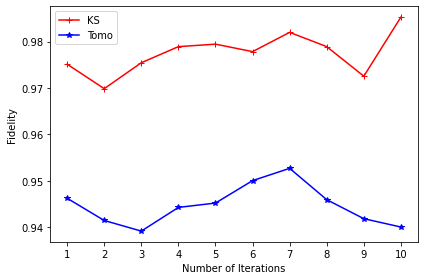

In [59]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_fed_qis.svg")
plt.show()

Iteration 1 KS Fid: 0.9751238261081833 Tomo Fid: 0.9462696414362606
Iteration 2 KS Fid: 0.9698547881523605 Tomo Fid: 0.9414831034220053
Iteration 3 KS Fid: 0.9754318068017753 Tomo Fid: 0.9391995684718868
Iteration 4 KS Fid: 0.9788969755875131 Tomo Fid: 0.944295528694833
Iteration 5 KS Fid: 0.9794368633695343 Tomo Fid: 0.945235151694162
Iteration 6 KS Fid: 0.9778249835294495 Tomo Fid: 0.9500608415714872
Iteration 7 KS Fid: 0.981973606994613 Tomo Fid: 0.9527067221627561
Iteration 8 KS Fid: 0.9788970594661659 Tomo Fid: 0.9459629167197218
Iteration 9 KS Fid: 0.9725404163532951 Tomo Fid: 0.9418712864314408
Iteration 10 KS Fid: 0.9852558641637873 Tomo Fid: 0.9400735275442823


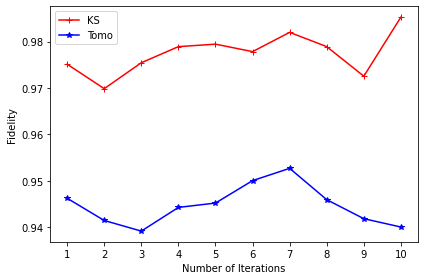

In [60]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 0.06571062963610429 Tomo Norm: 0.09185528841730818
Iteration 2 KS Norm: 0.06952401593303774 Tomo Norm: 0.10165721020106024
Iteration 3 KS Norm: 0.07097250534726701 Tomo Norm: 0.09674697983805347
Iteration 4 KS Norm: 0.06845746512488939 Tomo Norm: 0.09260881904639025
Iteration 5 KS Norm: 0.0650887989394933 Tomo Norm: 0.09068417005443226
Iteration 6 KS Norm: 0.06687733815172905 Tomo Norm: 0.09461849133176234
Iteration 7 KS Norm: 0.0673818001551706 Tomo Norm: 0.08885919583245001
Iteration 8 KS Norm: 0.0650750865056518 Tomo Norm: 0.09740241728032667
Iteration 9 KS Norm: 0.06844639778354121 Tomo Norm: 0.09447299339090132
Iteration 10 KS Norm: 0.06625505479546008 Tomo Norm: 0.09852003622325411


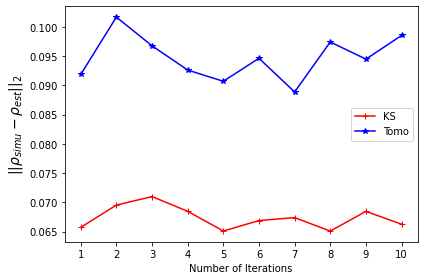

In [61]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_norm.svg")
plt.show()

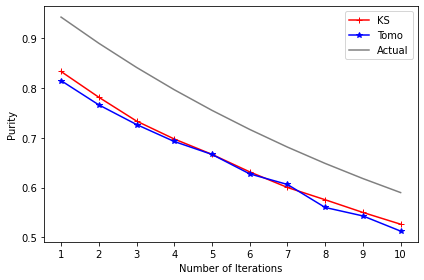

In [62]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("diff_pur.svg")
plt.show()

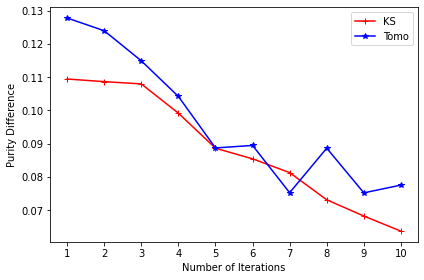

In [63]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()